## Here we are trying to analyse the basic concepts of time series analysis. we are using the Air passengers data over time. Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series

In [29]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [30]:
#reading the data
ts = pd.read_csv("../data/AirPassengers.csv")
ts.Month = pd.to_datetime(ts.Month) 

In [31]:
#checking for null values
ts = ts.sort_values('Month')
ts.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [32]:
ts.set_index('Month', inplace=True)
ts.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [33]:
#resampling the data with a monthly start frequency i.e the data will be recorded on fist day of the each month
#y = furniture['Sales'].resample('MS').mean()

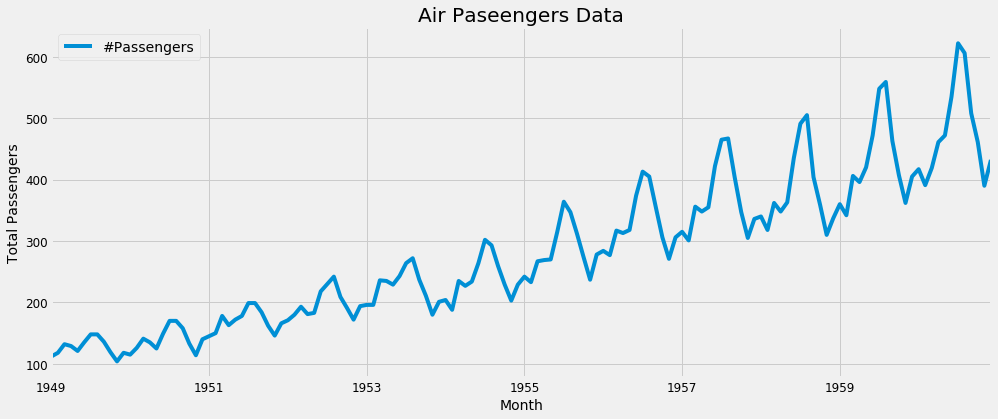

In [34]:
#plotting the time series distribution of the sales data for the technology product
ax = ts.plot(figsize=(15, 6), title= 'Air Paseengers Data')
ax.set_ylabel("Total Passengers")
plt.show()

### Now we have to check the stationarity of the time series data whose characteristics are, 

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.

### We can check the stationarity by obersving the following,
1. Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.



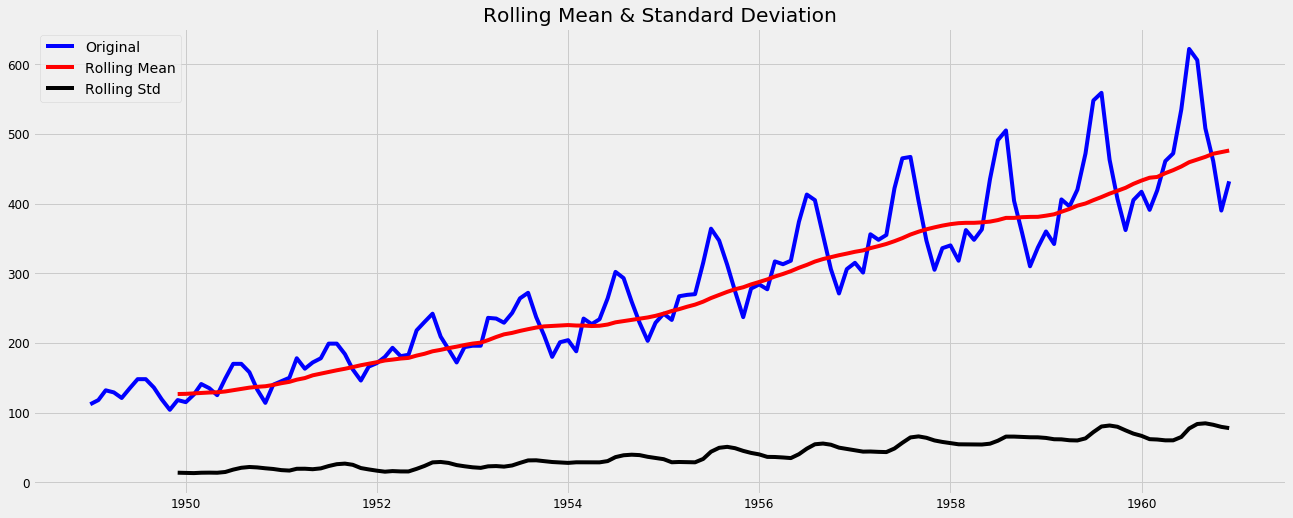

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [35]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    fig = plt.figure(figsize=(20,8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(ts)    

As we can cleary observe from the above results that the P-Value > significance level of (0.01, 99% confidence interval) and in other the Test statistic is not less than the critical value of the same confidence interval. So, we can't reject the null hypothesis and conclude that the time series is stationary.

Note: Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### Estimating & Eliminating Trend:
One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

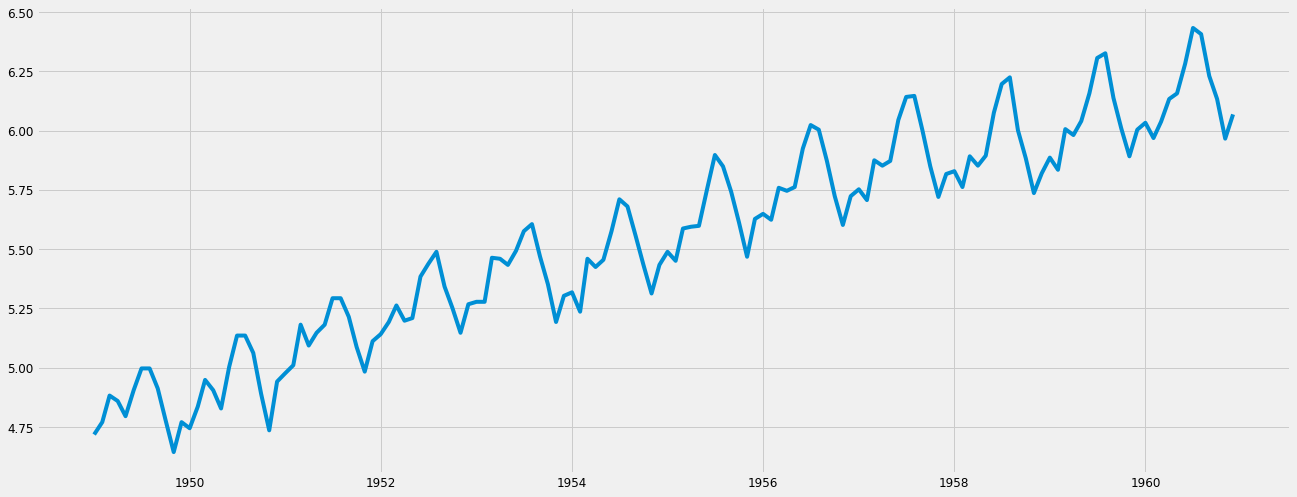

In [36]:
fig = plt.figure(figsize=(20, 8))
ts_log = np.log(ts)
plt.plot(ts_log)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model
I will discuss smoothing here and you should try other techniques as well which might work out for other problems. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. There are can be various ways but I will discuss two of those here.

### Moving average
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

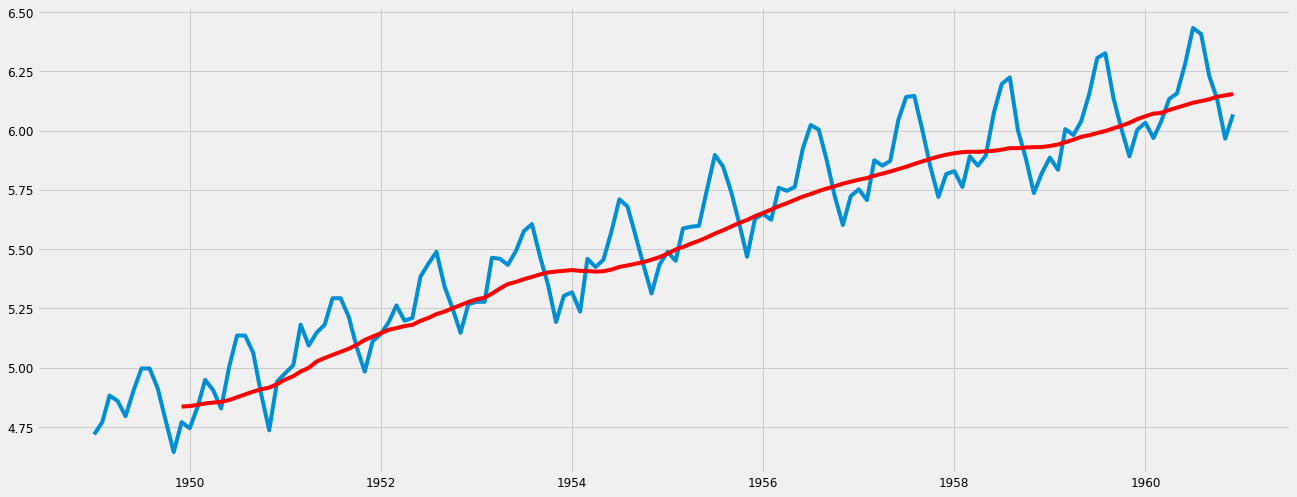

In [37]:
fig = plt.figure(figsize=(20, 8))
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [38]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


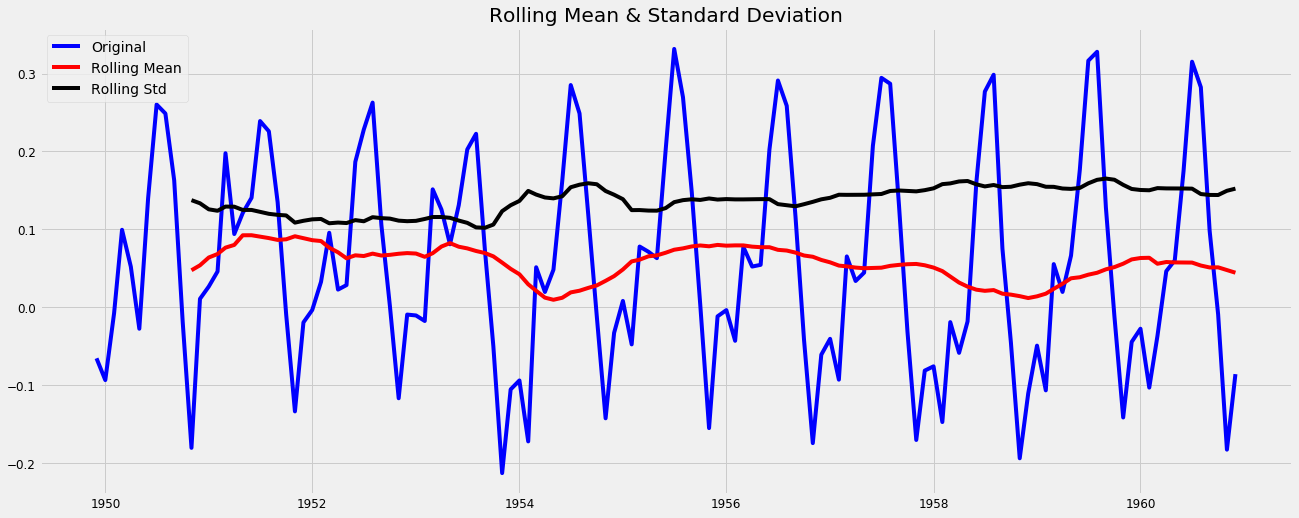

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [39]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

### Exponential Smoothing

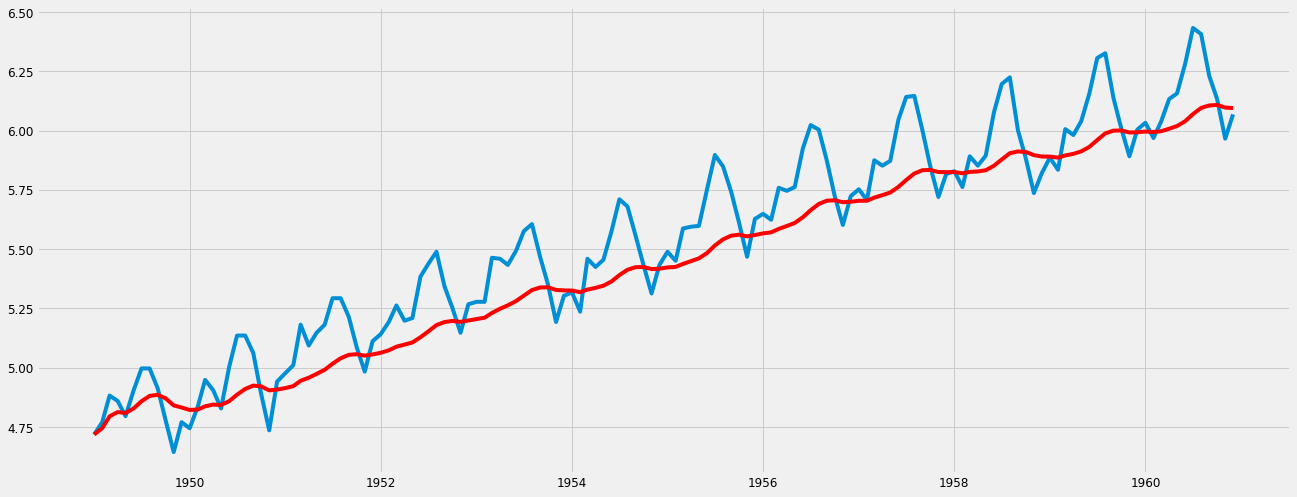

In [40]:
fig = plt.figure(figsize=(20, 8))
expwighted_avg = ts_log.ewm(12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

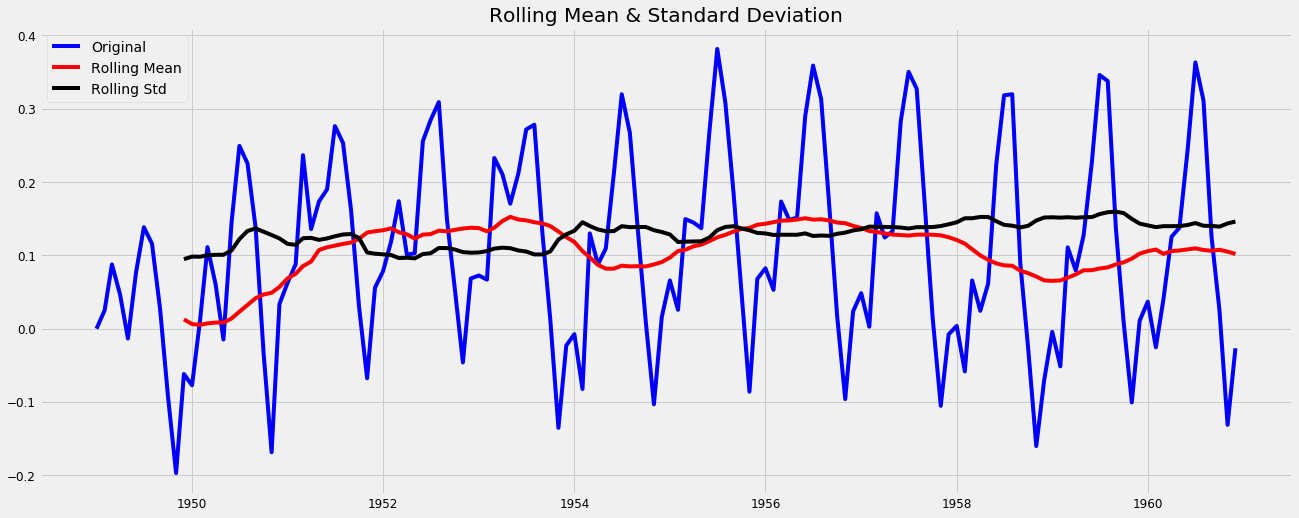

Results of Dickey-Fuller Test:
Test Statistic                  -3.566092
p-value                          0.006443
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [41]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the differece with a particular time lag

Decomposition – modeling both trend and seasonality and removing them from the model.


### Differencing
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

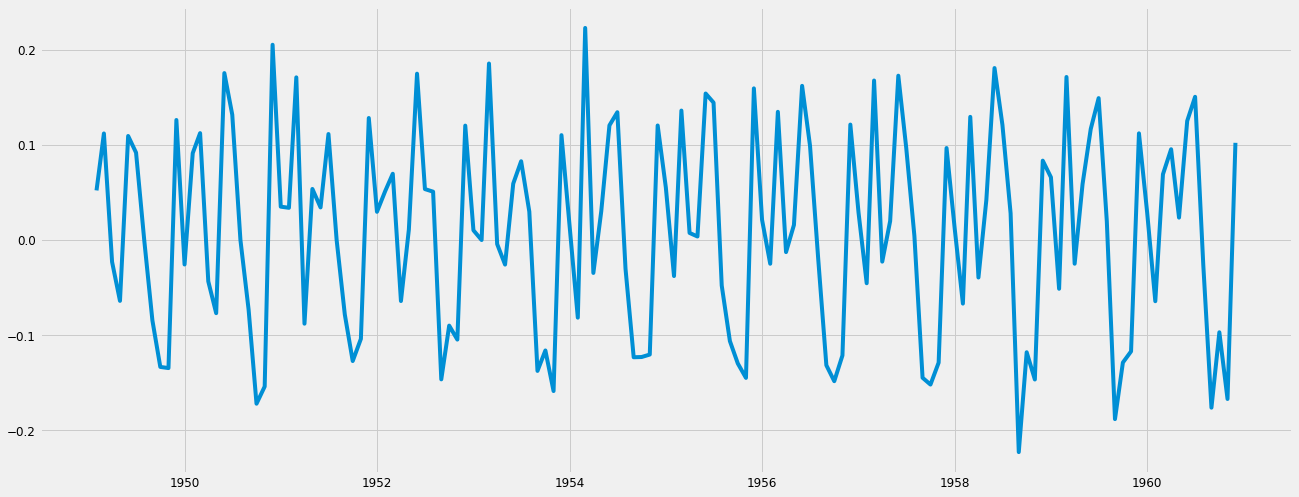

In [42]:
fig = plt.figure(figsize=(20, 8))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

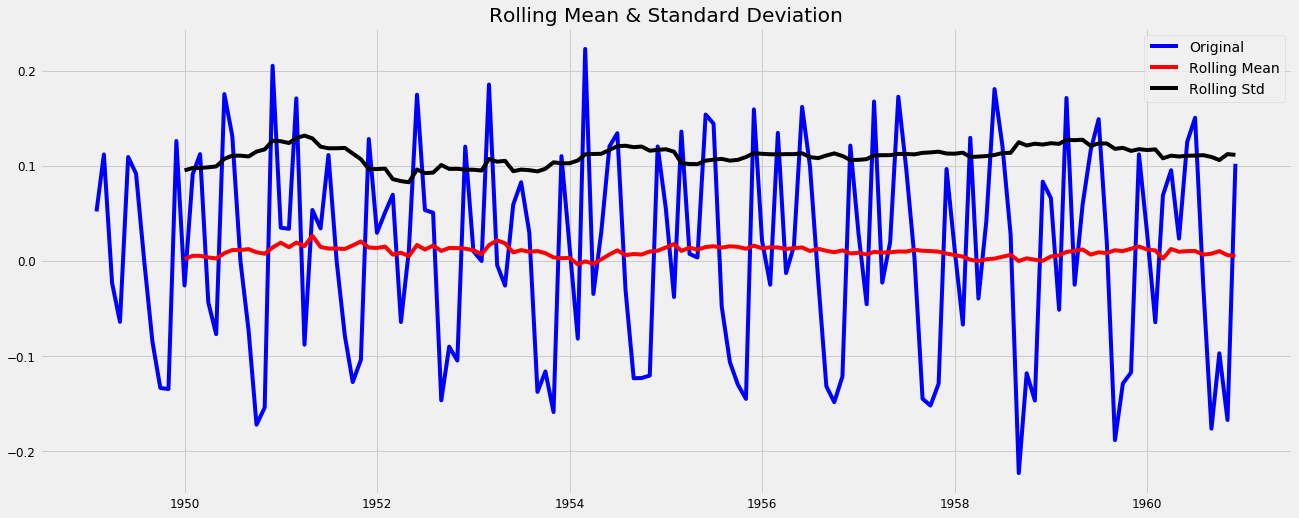

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [43]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Decomposing
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

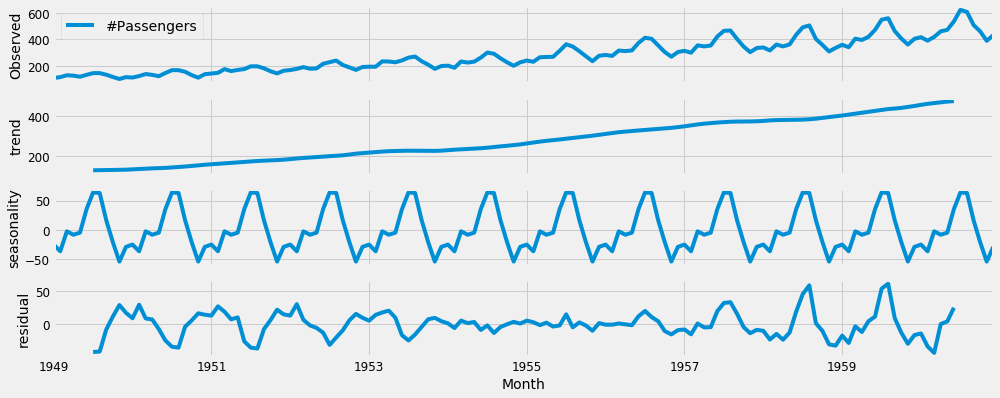

In [44]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
#fig = decomposition.plot()
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1)
ts.plot(figsize=(15, 6), ax=ax1)
ax1.set_ylabel("Observed")
decomposition.trend.plot(ax=ax2, sharex = ax1)
ax2.set_ylabel("trend")
decomposition.seasonal.plot(ax=ax3, sharex = ax1)
ax3.set_ylabel("seasonality")
decomposition.resid.plot(ax=ax4, sharex = ax1)
ax4.set_ylabel("residual")
#fig.tight_layout()
plt.show()

## Time series forecasting with ARIMA
### We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average. ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [45]:
from statsmodels.tsa.arima_model import ARIMA

### For ARIMA,

#### Number of AR (Auto-Regressive) terms (p): 
AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
#### Number of MA (Moving Average) terms (q): 
MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
#### Number of Differences (d): 
These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [46]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [47]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

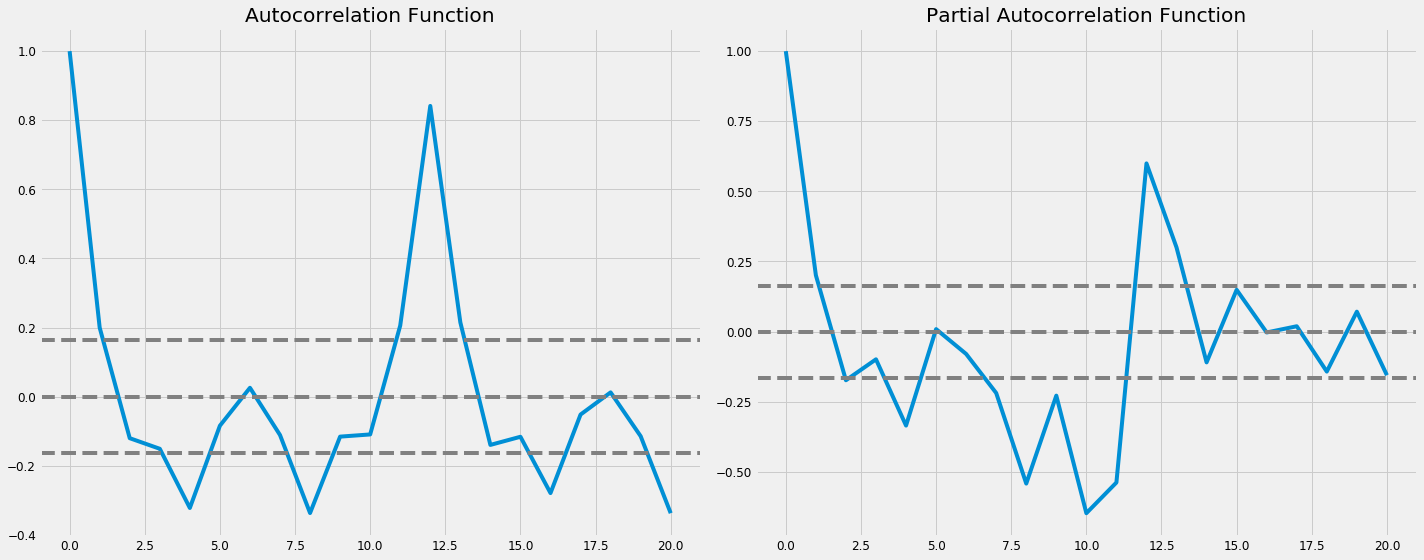

In [48]:
fig = plt.figure(figsize=(20,8))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [49]:
from statsmodels.tsa.arima_model import ARIMA

## AR Model

Text(0.5, 1.0, 'RSS: 1.5023')

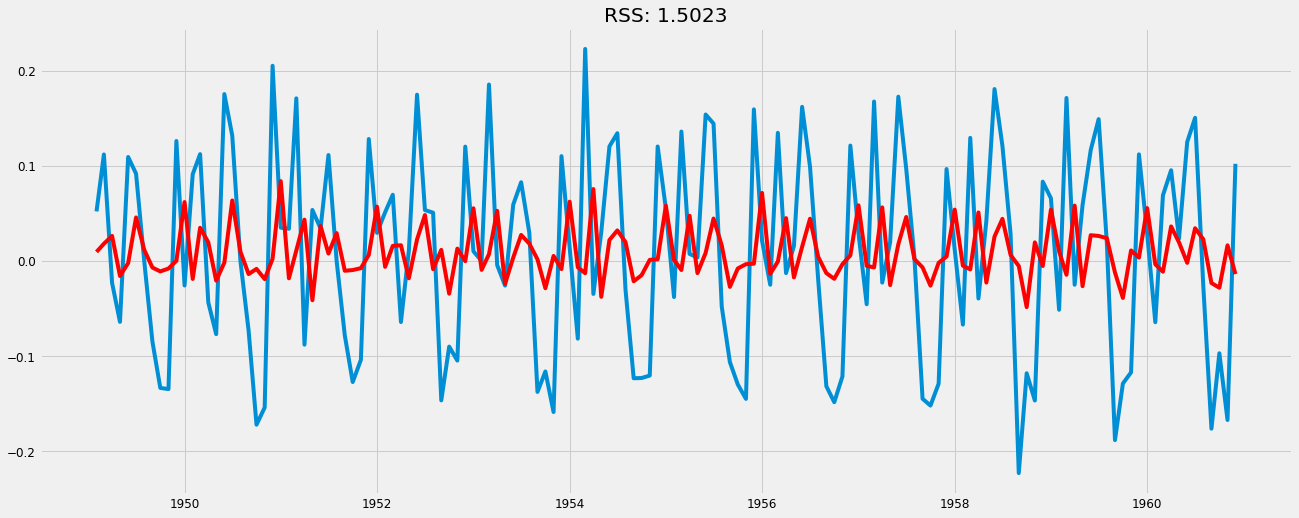

In [50]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff.iloc[:,0])**2))

### MR Model

Text(0.5, 1.0, 'RSS: 1.4721')

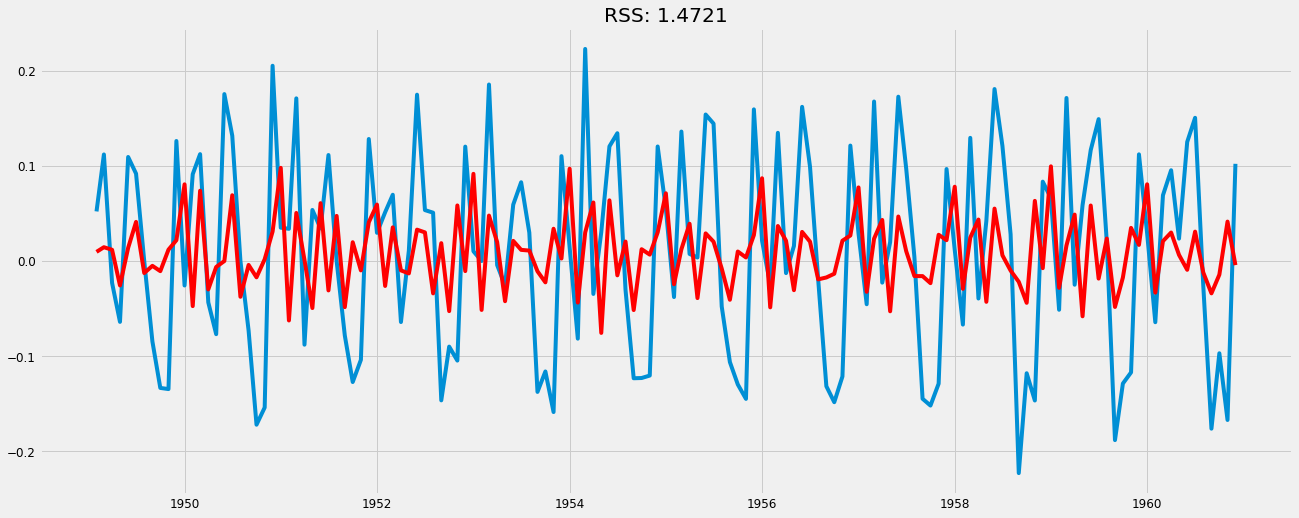

In [51]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff.iloc[:,0])**2))

### Combined Model

Text(0.5, 1.0, 'RSS: 1.0292')

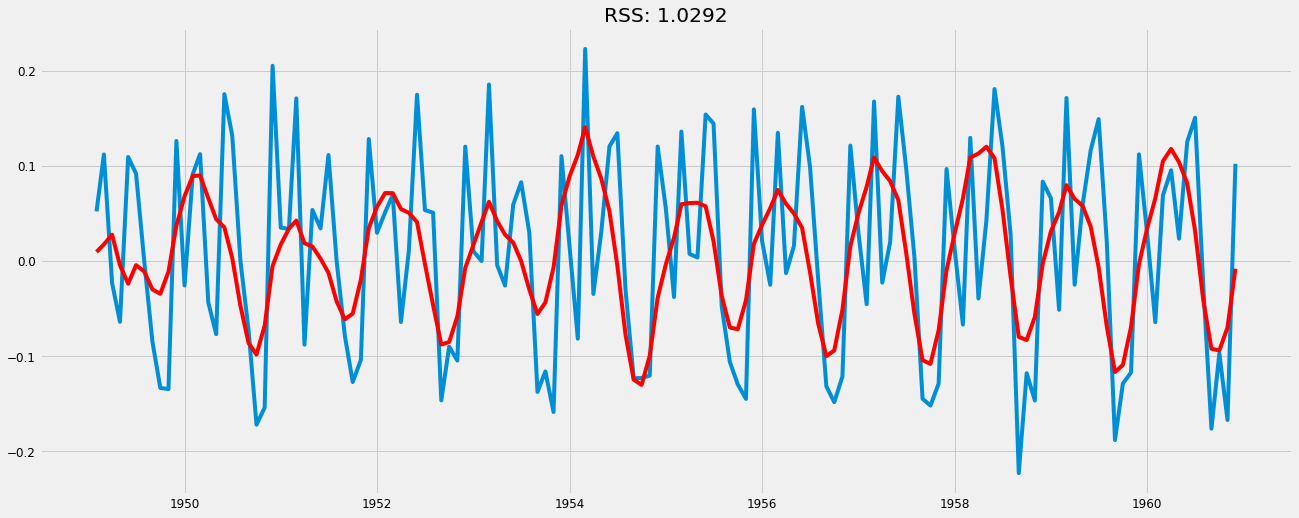

In [52]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff.iloc[:,0])**2))

### Taking it back to original scale

In [53]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number

In [54]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [55]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0, 0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1045')

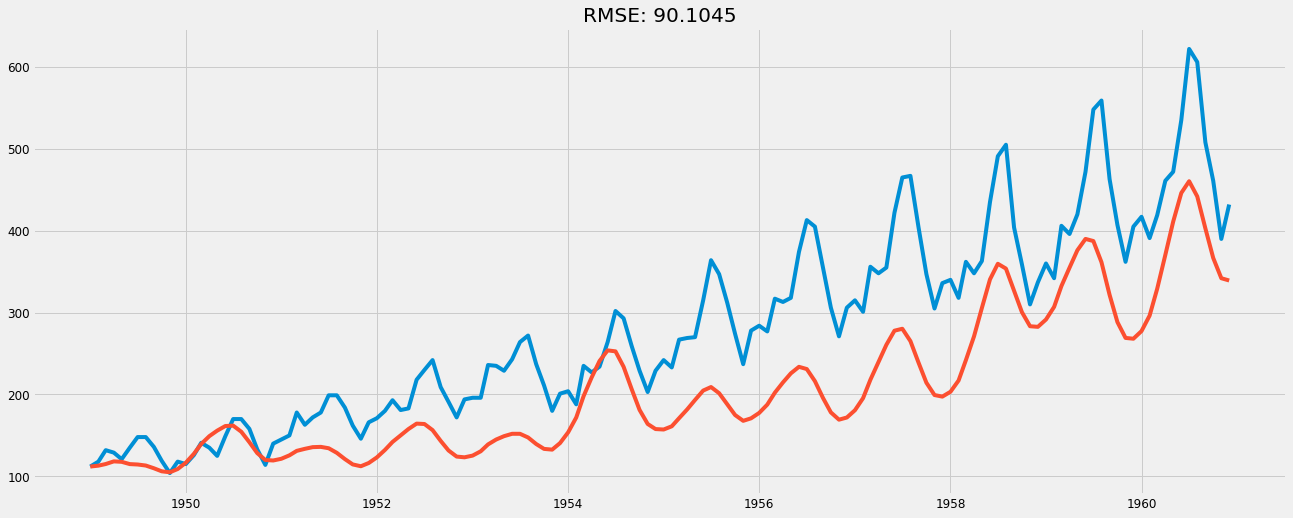

In [56]:
fig = plt.figure(figsize=(20,8))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts.iloc[:,0])**2)/len(ts)))